# Classifier using LSTM layers

## 1. Importing Libraries

In [14]:
import torch

import numpy as np
import pandas as pd

data_folder = '../data/ctrpts'

EPOCHS = 10
BATCH_SIZE = 64

MAX_SEQ_LENGTH = 95

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## 2. Data Preprocessing

### 2.1. Loading the data

In [15]:
import os


def get_categories_from_data(folder, n=None):
    """
    This function retrieves category names from file names in a specified folder. 
    The category name is assumed to be a substring of the file name, starting from the 17th character and ending 7 characters before the end of the file name.
    If the substring is empty, it is not added to the list of categories.
    If a limit 'n' is specified, only the first 'n' categories are returned.

    Parameters:
    folder (str): The path to the folder containing the files.
    n (int, optional): The maximum number of categories to return. If not specified, all categories are returned.

    Returns:
    list: A list of category names.
    """
    files = os.listdir(folder)
    categories = [file[16:-7] for file in files if len(file[16:-7]) > 0]
    return categories if n is None else categories[:n]

#classes = get_categories_from_data(data_folder)
classes = ["calculator", "camera", "cell phone"]
class_id = dict(zip(classes, range(len(classes))))

calculator_data = np.load(f'../data/ctrlpts/calculator_ctrlpt.npz', allow_pickle=True, encoding='latin1')
camera_data = np.load(f'../data/ctrlpts/camera_ctrlpt.npz', allow_pickle=True, encoding='latin1')
cellphone_data = np.load(f'../data/ctrlpts/cell_phone_ctrlpt.npz', allow_pickle=True, encoding='latin1')

class_id

{'calculator': 0, 'camera': 1, 'cell phone': 2}

In [16]:
calculator_data.get('train').shape, camera_data.get('train').shape, cellphone_data.get('train').shape

((17928,), (17938,), (17976,))

In [17]:
from sklearn.model_selection import train_test_split

# Limiting data to 5000 points per class
def slice_data(data):
    # Assuming that the data arrays in each 'train', 'test', 'valid' are already shuffled
    sliced = []
    for key in ['train', 'test', 'valid']:
        # Slicing each segment
        sliced.append(data[key])
    # Concatenate slices from train, test, valid
    return np.concatenate(sliced)

# Slicing the data
calculator_sliced = slice_data(calculator_data)[:5000]
camera_sliced = slice_data(camera_data)[:5000]
cellphone_sliced = slice_data(cellphone_data)[:5000]

# Concatenate all sliced data
def concatenate_data(*datasets):
    features = []
    labels = []
    for data, cid in zip(datasets, class_id.values()):
        features.append(data)
        labels.extend([cid] * len(data))
    features = np.concatenate(features)
    labels = np.array(labels)
    return features, labels

features, labels = concatenate_data(calculator_sliced, camera_sliced, cellphone_sliced)

# Split into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [18]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12000,), (12000,), (3000,), (3000,))

In [19]:
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
from scipy.interpolate import interp1d

def standardize_lengths(data, target_length=29):
    standardized_data = []

    for sequence in data:
        # Current length of the sequence
        current_length = sequence.shape[0]
        
        # Create an array of indices based on current length
        current_indices = np.linspace(0, 1, current_length)
        
        # Target indices for interpolation
        target_indices = np.linspace(0, 1, target_length)
        
        # Initialize interpolated sequence
        interpolated_sequence = np.zeros((target_length, sequence.shape[1]))
        
        # Interpolate each channel
        for i in range(sequence.shape[1]):
            # Interpolate the i-th channel
            interpolator = interp1d(current_indices, sequence[:, i], kind='linear')
            interpolated_sequence[:, i] = interpolator(target_indices)
        
        # Append the interpolated sequence to the standardized data list
        standardized_data.append(interpolated_sequence)

    return np.array(standardized_data)

# Apply standardization on X_train and X_test
X_train_standardized = standardize_lengths(X_train)
X_test_standardized = standardize_lengths(X_test)

def convert_to_tensor_datasets(X_train, X_test, y_train, y_test):
    """
    Convert numpy arrays into TensorFlow tensor datasets ready for model training.

    Args:
    X_train (np.array): Training features.
    X_test (np.array): Testing features.
    y_train (np.array): Training labels.
    y_test (np.array): Testing labels.
    batch_size (int): Size of batches for the dataset.

    Returns:
    tuple: TensorFlow datasets for training and testing.
    """
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.long).to(device))
    test_dataset = TensorDataset(torch.tensor(X_test).to(device, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long).to(device))

    return train_dataset, test_dataset

train_dataset, test_dataset = convert_to_tensor_datasets(X_train_standardized, X_test_standardized, y_train, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [20]:
print(len(train_loader))
print(len(test_loader))

188
47


In [21]:
X_train_standardized.shape, X_test_standardized.shape

((12000, 29, 3), (3000, 29, 3))

## 3. Model Building

### 3.1. Quantum Layer

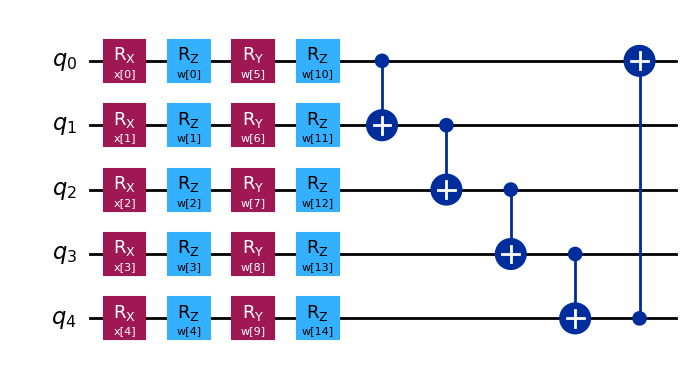

In [22]:
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector


def quantum_feature_map(n: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n)
    features = ParameterVector("x", n)

    for i in range(n):
        circuit.rx(features[i], i)

    return circuit

def quantum_ansatz(n: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n)
    weights = ParameterVector("w", n * 3)

    for i in range(n):
        circuit.rz(weights[i], i)

    for i in range(n):
        circuit.ry(weights[n+i], i)

    for i in range(n):
        circuit.rz(weights[2*n+i], i)

    for i in range(n-1):
        circuit.cx(i, i+1)
    circuit.cx(n-1, 0)

    return circuit

def create_qnn(n):
    feature_map = quantum_feature_map(n)
    ansatz = quantum_ansatz(n)

    qc = QuantumCircuit(n)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn, qc

qnn, qc = create_qnn(5)
qc.draw("mpl")

### 3.2. Hybrid Neural Network

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from qiskit_machine_learning.connectors import TorchConnector

class HybridNN(nn.Module):
    def __init__(self, input_shape, num_categories, n_qubits=5, fname=None):
        super(HybridNN, self).__init__()
        self.num_categories = num_categories

        # Convolutional layers
        #self.conv1 = nn.Conv1d(in_channels=input_shape[1], out_channels=16, kernel_size=4)
        #self.bn1 = nn.BatchNorm1d(num_features=16)
        #self.pool1 = nn.AvgPool1d(kernel_size=2)
        
        #self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5)
        #self.bn2 = nn.BatchNorm1d(num_features=32)
        #self.pool2 = nn.AvgPool1d(kernel_size=2)
        
        #self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        #self.bn3 = nn.BatchNorm1d(num_features=64)
        #self.pool3 = nn.AvgPool1d(kernel_size=2)
        
        #self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        #self.bn4 = nn.BatchNorm1d(num_features=128)
        #self.pool4 = nn.AvgPool1d(kernel_size=2)

        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=29, hidden_size=29, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=29, hidden_size=29, batch_first=True)
        
        self.pool5 = nn.AvgPool1d(kernel_size=2)

        # Dense layers
        self.fc1 = nn.Linear(14, 14)
        self.fc2 = nn.Linear(14, 14)

        # Quantum layer
        self.fc3 = nn.Linear(14, n_qubits)
        self.qnn = TorchConnector(create_qnn(n_qubits)[0])

        # Dense layer for classification
        self.fc4 = nn.Linear(2**n_qubits, num_categories)

        # Load pre-trained weights
        if fname:
            self.load_state_dict(torch.load(fname))

    def forward(self, x):
        #x = x.permute(0, 2, 1)

        # Convolutional layers
        #x = F.relu(self.bn1(self.conv1(x)))
        #x = self.pool1(x)
        
        #x = F.relu(self.bn2(self.conv2(x)))
        #x = self.pool2(x)
        
        #x = F.relu(self.bn3(self.conv3(x)))
        #x = self.pool3(x)
        
        #x = F.relu(self.bn4(self.conv4(x)))
        #x = self.pool4(x)

        # Reshape for LSTM
        #x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]

        # Pool layer
        x = self.pool5(x)

        # Flatten the output for dense layer
        x = torch.flatten(x, 1)

        # Dense layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Quantum layer
        x = F.relu(self.fc3(x))
        x = self.qnn(x)

        # Dense layer for classification
        x = F.relu(self.fc4(x))
        return x

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32)
            x = x.unsqueeze(0)
            prediction = self.forward(x)
        return prediction.numpy()

## 4. Training the Model

In [24]:
checkpoint_filepath = 'models/2edition_quantum_lstm/best_model_weights_3classes_ctrlpts.pth'

In [ ]:
from tqdm import tqdm

input_shape = (95, 3)
model = HybridNN(input_shape, len(classes)).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Function to evaluate the model on validation data
def evaluate(model, test_loader):
    model.eval()
    total_correct = 0
    total_loss = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)

            total_loss += criterion(outputs, targets)
            total_correct += (predicted == targets).sum().item()
    model.train()
    return total_correct / total_samples, total_loss / len(test_loader)

# Training loop
best_accuracy = 0
accuracy_list = []
loss_list = []

val_accuracy_list = []
val_loss_list = []

for epoch in range(100):
    model.train()

    total_loss = []
    
    total_correct = 0
    total_samples = 0
    for inputs, labels in tqdm(train_loader):
        # Forward pass
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()

        # Backward pass
        optimizer.step()
        total_loss.append(loss.item())

        total_samples += 1

    # Evaluate the model on the validation data after each epoch
    val_accuracy, val_loss = evaluate(model, test_loader)
    val_accuracy_list.append(val_accuracy)
    val_loss_list.append(val_loss)
    
    accuracy_list.append(total_correct / len(train_loader.dataset))
    loss_list.append(sum(total_loss) / len(train_loader))
    
    print(f'Epoch {epoch + 1}, Accuracy: {total_correct / len(train_loader.dataset)}, Loss: {sum(total_loss) / len(train_loader)}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Checkpointing
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), checkpoint_filepath)

100%|██████████| 188/188 [23:50<00:00,  7.61s/it]


Epoch 1, Accuracy: 0.4860833333333333, Loss: 1.0475669401757262, Validation Accuracy: 0.6343333333333333, Validation Loss: 0.9596485495567322


100%|██████████| 188/188 [26:10<00:00,  8.35s/it]


Epoch 2, Accuracy: 0.6240833333333333, Loss: 0.8996456173506189, Validation Accuracy: 0.646, Validation Loss: 0.8589529395103455


100%|██████████| 188/188 [24:56<00:00,  7.96s/it]


Epoch 3, Accuracy: 0.6395833333333333, Loss: 0.8157380432524579, Validation Accuracy: 0.6486666666666666, Validation Loss: 0.7878950238227844


100%|██████████| 188/188 [24:54<00:00,  7.95s/it]


Epoch 4, Accuracy: 0.6489166666666667, Loss: 0.7543121617525181, Validation Accuracy: 0.6576666666666666, Validation Loss: 0.7370515465736389


100%|██████████| 188/188 [24:45<00:00,  7.90s/it]


Epoch 5, Accuracy: 0.65975, Loss: 0.7089593733878846, Validation Accuracy: 0.6686666666666666, Validation Loss: 0.700410783290863


100%|██████████| 188/188 [24:42<00:00,  7.88s/it]


Epoch 6, Accuracy: 0.6791666666666667, Loss: 0.6734753542758048, Validation Accuracy: 0.6803333333333333, Validation Loss: 0.6752294898033142


100%|██████████| 188/188 [24:24<00:00,  7.79s/it]


Epoch 7, Accuracy: 0.7109166666666666, Loss: 0.6446720770698913, Validation Accuracy: 0.7186666666666667, Validation Loss: 0.6522438526153564


100%|██████████| 188/188 [24:03<00:00,  7.68s/it]


Epoch 8, Accuracy: 0.7465, Loss: 0.6136818169913394, Validation Accuracy: 0.7516666666666667, Validation Loss: 0.622687578201294


100%|██████████| 188/188 [23:49<00:00,  7.60s/it]


Epoch 9, Accuracy: 0.79125, Loss: 0.5772364627807698, Validation Accuracy: 0.783, Validation Loss: 0.5819386839866638


100%|██████████| 188/188 [23:47<00:00,  7.59s/it]


Epoch 10, Accuracy: 0.8325, Loss: 0.5347466479907644, Validation Accuracy: 0.8313333333333334, Validation Loss: 0.5315425992012024


100%|██████████| 188/188 [23:47<00:00,  7.60s/it]


Epoch 11, Accuracy: 0.8466666666666667, Loss: 0.483980563092739, Validation Accuracy: 0.837, Validation Loss: 0.4826330542564392


100%|██████████| 188/188 [24:00<00:00,  7.66s/it]


Epoch 12, Accuracy: 0.8636666666666667, Loss: 0.4168720364253572, Validation Accuracy: 0.8466666666666667, Validation Loss: 0.4469490051269531


100%|██████████| 188/188 [23:59<00:00,  7.66s/it]


Epoch 13, Accuracy: 0.8749166666666667, Loss: 0.38017481153315685, Validation Accuracy: 0.8636666666666667, Validation Loss: 0.4125426411628723


100%|██████████| 188/188 [23:58<00:00,  7.65s/it]


Epoch 14, Accuracy: 0.8819166666666667, Loss: 0.3522132475008356, Validation Accuracy: 0.8723333333333333, Validation Loss: 0.3740292489528656


100%|██████████| 188/188 [23:45<00:00,  7.58s/it]


Epoch 15, Accuracy: 0.8971666666666667, Loss: 0.31950936720092243, Validation Accuracy: 0.8716666666666667, Validation Loss: 0.3866071105003357


100%|██████████| 188/188 [23:53<00:00,  7.62s/it]


Epoch 16, Accuracy: 0.90225, Loss: 0.30260281930578514, Validation Accuracy: 0.8796666666666667, Validation Loss: 0.34933334589004517


100%|██████████| 188/188 [23:53<00:00,  7.63s/it]


Epoch 17, Accuracy: 0.908, Loss: 0.2785867326595682, Validation Accuracy: 0.888, Validation Loss: 0.337133526802063


100%|██████████| 188/188 [23:52<00:00,  7.62s/it]


Epoch 18, Accuracy: 0.9083333333333333, Loss: 0.27384989447099095, Validation Accuracy: 0.877, Validation Loss: 0.34870755672454834


100%|██████████| 188/188 [23:54<00:00,  7.63s/it]


Epoch 19, Accuracy: 0.9155833333333333, Loss: 0.25514069211451296, Validation Accuracy: 0.8943333333333333, Validation Loss: 0.31462785601615906


100%|██████████| 188/188 [23:52<00:00,  7.62s/it]


Epoch 20, Accuracy: 0.9211666666666667, Loss: 0.24324388936796087, Validation Accuracy: 0.8973333333333333, Validation Loss: 0.30699101090431213


100%|██████████| 188/188 [23:56<00:00,  7.64s/it]


Epoch 21, Accuracy: 0.9255833333333333, Loss: 0.22872869190859033, Validation Accuracy: 0.8933333333333333, Validation Loss: 0.3091898560523987


100%|██████████| 188/188 [24:08<00:00,  7.70s/it]


Epoch 22, Accuracy: 0.9273333333333333, Loss: 0.22015466755057903, Validation Accuracy: 0.8956666666666667, Validation Loss: 0.30623042583465576


100%|██████████| 188/188 [24:05<00:00,  7.69s/it]


Epoch 23, Accuracy: 0.9310833333333334, Loss: 0.21596166408283912, Validation Accuracy: 0.9046666666666666, Validation Loss: 0.2941505014896393


100%|██████████| 188/188 [32:35<00:00, 10.40s/it]


Epoch 24, Accuracy: 0.9379166666666666, Loss: 0.20015091024973292, Validation Accuracy: 0.8923333333333333, Validation Loss: 0.31528398394584656


100%|██████████| 188/188 [32:10<00:00, 10.27s/it]


Epoch 25, Accuracy: 0.9385833333333333, Loss: 0.19313982442179892, Validation Accuracy: 0.905, Validation Loss: 0.29258522391319275


100%|██████████| 188/188 [32:16<00:00, 10.30s/it]


Epoch 26, Accuracy: 0.9420833333333334, Loss: 0.18307673849878794, Validation Accuracy: 0.9026666666666666, Validation Loss: 0.2882770895957947


100%|██████████| 188/188 [32:12<00:00, 10.28s/it]


Epoch 27, Accuracy: 0.9413333333333334, Loss: 0.18708981724178536, Validation Accuracy: 0.894, Validation Loss: 0.3053736686706543


100%|██████████| 188/188 [32:06<00:00, 10.25s/it]


Epoch 28, Accuracy: 0.9475833333333333, Loss: 0.17015303657489253, Validation Accuracy: 0.8996666666666666, Validation Loss: 0.2882392108440399


100%|██████████| 188/188 [32:09<00:00, 10.26s/it]


Epoch 29, Accuracy: 0.94575, Loss: 0.17213583993230094, Validation Accuracy: 0.9013333333333333, Validation Loss: 0.28319481015205383


100%|██████████| 188/188 [29:43<00:00,  9.49s/it]


Epoch 30, Accuracy: 0.9493333333333334, Loss: 0.16243912852270173, Validation Accuracy: 0.8976666666666666, Validation Loss: 0.31355059146881104


100%|██████████| 188/188 [29:40<00:00,  9.47s/it]


Epoch 31, Accuracy: 0.94925, Loss: 0.15726043965588224, Validation Accuracy: 0.901, Validation Loss: 0.29141849279403687


100%|██████████| 188/188 [28:06<00:00,  8.97s/it]


Epoch 32, Accuracy: 0.9536666666666667, Loss: 0.1521075804262085, Validation Accuracy: 0.9003333333333333, Validation Loss: 0.2936927378177643


100%|██████████| 188/188 [26:36<00:00,  8.49s/it]


Epoch 33, Accuracy: 0.9554166666666667, Loss: 0.14721668541352165, Validation Accuracy: 0.9073333333333333, Validation Loss: 0.285704106092453


100%|██████████| 188/188 [26:31<00:00,  8.46s/it]


Epoch 34, Accuracy: 0.9575, Loss: 0.1412343713553979, Validation Accuracy: 0.9013333333333333, Validation Loss: 0.30609437823295593


100%|██████████| 188/188 [26:31<00:00,  8.46s/it]


Epoch 35, Accuracy: 0.9605833333333333, Loss: 0.13410432337525677, Validation Accuracy: 0.9023333333333333, Validation Loss: 0.2917558252811432


100%|██████████| 188/188 [26:32<00:00,  8.47s/it]


Epoch 36, Accuracy: 0.9625833333333333, Loss: 0.12898202313783955, Validation Accuracy: 0.902, Validation Loss: 0.301636666059494


100%|██████████| 188/188 [26:30<00:00,  8.46s/it]


Epoch 37, Accuracy: 0.9605833333333333, Loss: 0.13211160503882677, Validation Accuracy: 0.906, Validation Loss: 0.30573752522468567


100%|██████████| 188/188 [26:32<00:00,  8.47s/it]


Epoch 38, Accuracy: 0.9646666666666667, Loss: 0.12103052921791344, Validation Accuracy: 0.9036666666666666, Validation Loss: 0.29316890239715576


100%|██████████| 188/188 [26:29<00:00,  8.45s/it]


Epoch 39, Accuracy: 0.965, Loss: 0.11772419213059734, Validation Accuracy: 0.8923333333333333, Validation Loss: 0.3307421803474426


100%|██████████| 188/188 [26:35<00:00,  8.49s/it]


Epoch 40, Accuracy: 0.9630833333333333, Loss: 0.12476653427361174, Validation Accuracy: 0.9033333333333333, Validation Loss: 0.30995675921440125


100%|██████████| 188/188 [26:27<00:00,  8.44s/it]


Epoch 41, Accuracy: 0.9685, Loss: 0.10982230942735964, Validation Accuracy: 0.899, Validation Loss: 0.3227735161781311


100%|██████████| 188/188 [26:32<00:00,  8.47s/it]


Epoch 42, Accuracy: 0.96975, Loss: 0.10798281015075267, Validation Accuracy: 0.904, Validation Loss: 0.3032959997653961


100%|██████████| 188/188 [26:36<00:00,  8.49s/it]


Epoch 43, Accuracy: 0.9714166666666667, Loss: 0.10226895275743718, Validation Accuracy: 0.904, Validation Loss: 0.31412801146507263


100%|██████████| 188/188 [26:34<00:00,  8.48s/it]


Epoch 44, Accuracy: 0.9719166666666667, Loss: 0.1001150389301016, Validation Accuracy: 0.8996666666666666, Validation Loss: 0.3159634470939636


100%|██████████| 188/188 [26:32<00:00,  8.47s/it]


Epoch 45, Accuracy: 0.9721666666666666, Loss: 0.09946438764281412, Validation Accuracy: 0.9026666666666666, Validation Loss: 0.3309779465198517


100%|██████████| 188/188 [27:12<00:00,  8.68s/it]


Epoch 46, Accuracy: 0.9723333333333334, Loss: 0.09782331084654211, Validation Accuracy: 0.8993333333333333, Validation Loss: 0.3426037132740021


100%|██████████| 188/188 [25:38<00:00,  8.18s/it]


Epoch 47, Accuracy: 0.9728333333333333, Loss: 0.09711353556114308, Validation Accuracy: 0.904, Validation Loss: 0.31752100586891174


100%|██████████| 188/188 [25:15<00:00,  8.06s/it]


Epoch 48, Accuracy: 0.9776666666666667, Loss: 0.08557575831110491, Validation Accuracy: 0.9043333333333333, Validation Loss: 0.3148755729198456


100%|██████████| 188/188 [26:59<00:00,  8.62s/it]


Epoch 49, Accuracy: 0.9739166666666667, Loss: 0.09049995523936888, Validation Accuracy: 0.9003333333333333, Validation Loss: 0.35361814498901367


100%|██████████| 188/188 [28:08<00:00,  8.98s/it]


Epoch 50, Accuracy: 0.9776666666666667, Loss: 0.08399050310254097, Validation Accuracy: 0.8963333333333333, Validation Loss: 0.3609826862812042


100%|██████████| 188/188 [32:37<00:00, 10.41s/it]


Epoch 51, Accuracy: 0.9765, Loss: 0.08423079541844732, Validation Accuracy: 0.9013333333333333, Validation Loss: 0.34346839785575867


100%|██████████| 188/188 [36:15<00:00, 11.57s/it]


Epoch 52, Accuracy: 0.9773333333333334, Loss: 0.08606778966025153, Validation Accuracy: 0.9066666666666666, Validation Loss: 0.32348233461380005


100%|██████████| 188/188 [39:05<00:00, 12.48s/it]


Epoch 53, Accuracy: 0.9778333333333333, Loss: 0.08409294819934889, Validation Accuracy: 0.9006666666666666, Validation Loss: 0.3442156910896301


100%|██████████| 188/188 [40:02<00:00, 12.78s/it]


Epoch 54, Accuracy: 0.97925, Loss: 0.0812874031253159, Validation Accuracy: 0.9023333333333333, Validation Loss: 0.3347075283527374


100%|██████████| 188/188 [40:23<00:00, 12.89s/it]


Epoch 55, Accuracy: 0.9800833333333333, Loss: 0.07964207861136566, Validation Accuracy: 0.892, Validation Loss: 0.39586108922958374


100%|██████████| 188/188 [42:44<00:00, 13.64s/it]


Epoch 56, Accuracy: 0.9756666666666667, Loss: 0.08596523060522815, Validation Accuracy: 0.9046666666666666, Validation Loss: 0.3353900909423828


100%|██████████| 188/188 [42:08<00:00, 13.45s/it]


Epoch 57, Accuracy: 0.98375, Loss: 0.06709177144604953, Validation Accuracy: 0.9023333333333333, Validation Loss: 0.35486671328544617


100%|██████████| 188/188 [41:19<00:00, 13.19s/it]


Epoch 58, Accuracy: 0.9864166666666667, Loss: 0.059915161637113766, Validation Accuracy: 0.9046666666666666, Validation Loss: 0.3485356867313385


100%|██████████| 188/188 [38:30<00:00, 12.29s/it]


Epoch 59, Accuracy: 0.9880833333333333, Loss: 0.05603474643121057, Validation Accuracy: 0.897, Validation Loss: 0.38634824752807617


100%|██████████| 188/188 [32:51<00:00, 10.49s/it]


Epoch 60, Accuracy: 0.984, Loss: 0.06482306337281268, Validation Accuracy: 0.8996666666666666, Validation Loss: 0.3723176121711731


100%|██████████| 188/188 [30:27<00:00,  9.72s/it]


Epoch 61, Accuracy: 0.9828333333333333, Loss: 0.06926521638091257, Validation Accuracy: 0.9026666666666666, Validation Loss: 0.35687240958213806


100%|██████████| 188/188 [29:32<00:00,  9.43s/it]


Epoch 62, Accuracy: 0.9828333333333333, Loss: 0.06553285063412834, Validation Accuracy: 0.8973333333333333, Validation Loss: 0.3903116285800934


100%|██████████| 188/188 [24:41<00:00,  7.88s/it]


Epoch 63, Accuracy: 0.9854166666666667, Loss: 0.059317212219924684, Validation Accuracy: 0.9053333333333333, Validation Loss: 0.36189496517181396


100%|██████████| 188/188 [22:30<00:00,  7.18s/it]


Epoch 64, Accuracy: 0.9876666666666667, Loss: 0.05505073440330539, Validation Accuracy: 0.906, Validation Loss: 0.3825075626373291


100%|██████████| 188/188 [22:30<00:00,  7.18s/it]


Epoch 65, Accuracy: 0.98225, Loss: 0.06880512511100065, Validation Accuracy: 0.9003333333333333, Validation Loss: 0.4066231846809387


100%|██████████| 188/188 [22:31<00:00,  7.19s/it]


Epoch 66, Accuracy: 0.9804166666666667, Loss: 0.07242958044554008, Validation Accuracy: 0.9006666666666666, Validation Loss: 0.3783895969390869


100%|██████████| 188/188 [22:31<00:00,  7.19s/it]


Epoch 67, Accuracy: 0.9873333333333333, Loss: 0.05529383678444998, Validation Accuracy: 0.9013333333333333, Validation Loss: 0.39892837405204773


100%|██████████| 188/188 [22:33<00:00,  7.20s/it]


Epoch 68, Accuracy: 0.9905833333333334, Loss: 0.04586772193904332, Validation Accuracy: 0.899, Validation Loss: 0.4095008969306946


100%|██████████| 188/188 [22:30<00:00,  7.19s/it]


Epoch 69, Accuracy: 0.9914166666666666, Loss: 0.04415163005196906, Validation Accuracy: 0.8996666666666666, Validation Loss: 0.42463091015815735


100%|██████████| 188/188 [22:30<00:00,  7.18s/it]


Epoch 70, Accuracy: 0.9900833333333333, Loss: 0.047390134854024234, Validation Accuracy: 0.9033333333333333, Validation Loss: 0.40519773960113525


 97%|█████████▋| 183/188 [22:03<00:35,  7.08s/it]

## 5. Model Evaluation

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(loss_list, val_loss_list, accuracy_list, val_accuracy_list):
    plt.figure(figsize=(10, 5))

    # Plotting loss
    plt.subplot(1, 2, 1)
    plt.plot(loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_list, label='Training Accuracy')
    plt.plot(val_accuracy_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plot_graphs(loss_list, val_loss_list, accuracy_list, val_accuracy_list)

In [ ]:
model = HybridNN(input_shape, num_categories=len(classes), fname=checkpoint_filepath)

In [ ]:
INDEX = 0

out = model.predict(X_test[:2500][INDEX])
print("Predicted class:", classes[np.argmax(out)])
print("True class:", classes[y_test[INDEX].astype(int)])